# How to determine the threshold value for an MPN experiment

[MicroMPN](https://github.com/USDA-ARS-GBRU/micrompn) is a command-line tool for calculating MPN values directly from microplates. In this notebook, we explain how to determine a threshold value to supply to MicroMPN. For additional resources on how to run MicroMPN see:
https://protocols.io/view/micrompn-software-for-automating-most-probable-num-cu5rwy56.html

# Input files

For this example, we converted the data from SpectraMax M3 plate reader to column format. with the python script `four_col_updated.py`. Some plate readers will export directly to this format.    

We will create a kernel density plot and histogram of RFU values at hour zero and hour 48 after incubation to select a threshold that delineates T0 RFUs from T48 wells with bacterial growth.

All of the data files used here can be found in:
https://github.com/USDA-ARS-GBRU/MicroMPN_data-files/

Data files:

* `MicroMPN_data-files/SpectraMax_output_to_column_format/example_t0_rfu.csv`
* `MicroMPN_data-files/SpectraMax_output_to_column_format/example_t0_rfu.csv/soil_only.csv`



In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [11]:
# import T0 data file

df_t0 = pd.read_csv('SpectraMax_output_to_column_format/example_t0_rfu.csv')
df_t0


,plate_unique,plate_id,plate_well,rfu
0,plate_0,RFP_1_plate_1,A1,15.762
1,plate_0,RFP_1_plate_1,A2,12.590
2,plate_0,RFP_1_plate_1,A3,4.075
3,plate_0,RFP_1_plate_1,A4,3.343
4,plate_0,RFP_1_plate_1,A5,3.136
...,...,...,...,...
2299,plate_23,RFP_3_plate_1,H8,2.615
2300,plate_23,RFP_3_plate_1,H9,2.684
2301,plate_23,RFP_3_plate_1,H10,2.428
2302,plate_23,RFP_3_plate_1,H11,2.667


Text(0, 0.5, 'Density')

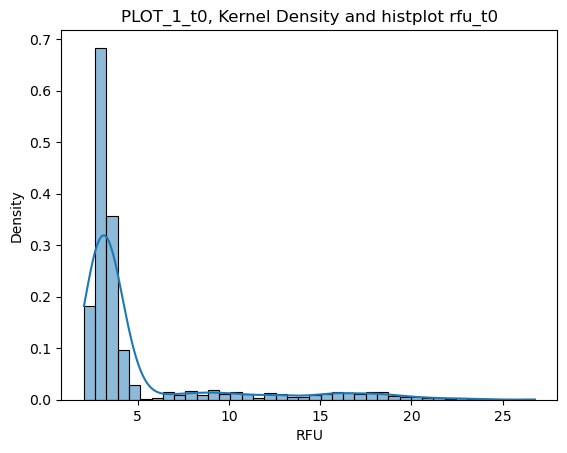

In [12]:
# PLOT_1_t0
# Plot a density kernel and histogram of all the data

sns.histplot(df_t0["rfu"], kde=True, bins=40, stat="density")
plt.title('PLOT_1_t0, Kernel Density and histplot rfu_t0')
plt.xlabel("RFU")
plt.ylabel('Density')

Most blank values are centered on an RFU of 3.2 but there is a long tail of higher RFU values. These are caused by soil particles in the first two wells of the dilution series. In the next step we will discard this data.

In [13]:
def filter_wells(df: pd.DataFrame) -> pd.DataFrame:
    """ Filter wells in columns 1 and 2 from the data
        
        Input:
            df:  a data frame with wells to be filtered
        
        Returns:
            A filtered pandas data frame
    """
    patternDel = "^[a-zA-Z](1|2)$"
    filter = df['plate_well'].str.contains(patternDel)
    return df[~filter].reset_index(drop=True)

In [14]:
df_t0cd = filter_wells(df_t0)
df_t0cd

,plate_unique,plate_id,plate_well,rfu
0,plate_0,RFP_1_plate_1,A3,4.075
1,plate_0,RFP_1_plate_1,A4,3.343
2,plate_0,RFP_1_plate_1,A5,3.136
3,plate_0,RFP_1_plate_1,A6,3.251
4,plate_0,RFP_1_plate_1,A7,3.141
...,...,...,...,...
1915,plate_23,RFP_3_plate_1,H8,2.615
1916,plate_23,RFP_3_plate_1,H9,2.684
1917,plate_23,RFP_3_plate_1,H10,2.428
1918,plate_23,RFP_3_plate_1,H11,2.667


In our work we chose a cutoff of $5\sigma$ greater than the means T0 well fluorescence. We calculate the mean, standard deviation, and $5\sigma$ level below. 

the mean value is 3.1983739583333333
the standard deviation is 0.5155337340936078
lower limit is 0.6207052878652943
upper limit is 5.776042628801372


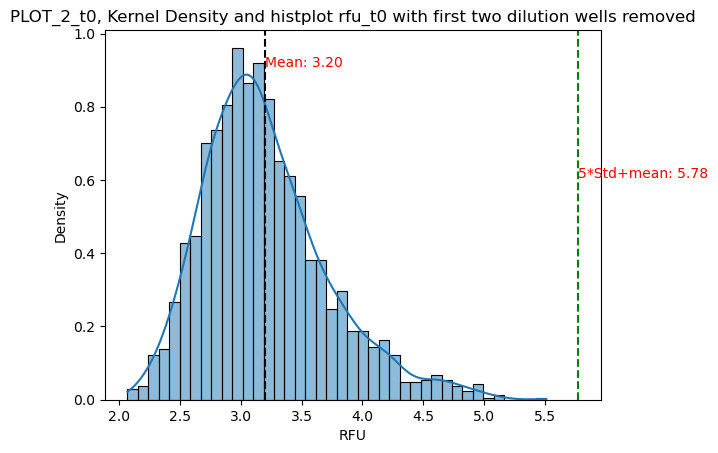

In [15]:
# PLOT_2_t0

# calculate standard deviations
mean_value_t0 = np.mean(df_t0cd["rfu"])
print("the mean value is", mean_value_t0)

std_dev_t0 = np.std(df_t0cd["rfu"])
print("the standard deviation is", std_dev_t0)

lower_limit_t0 = mean_value_t0 - (5*std_dev_t0)
upper_limit_t0 = mean_value_t0 + (5*std_dev_t0) 
print("lower limit is", lower_limit_t0)
print("upper limit is", upper_limit_t0)

#add mean value and 5X the standard deviation to plot
sns.histplot(
    df_t0cd["rfu"], kde=True, bins=40, stat="density")
plt.title('PLOT_2_t0, Kernel Density and histplot rfu_t0 with first two dilution wells removed')
plt.xlabel("RFU")
plt.ylabel('Density')
#plt.xlim(mean_value_t0, upper_limit_t0)

plt.text(mean_value_t0, plt.ylim()[1] * 0.9, f'Mean: {mean_value_t0:.2f}', color='red')
plt.text(upper_limit_t0, plt.ylim()[1] * 0.6, f'5*Std+mean: {upper_limit_t0:.2f}', color='red')

plt.axvline(mean_value_t0, color='black', linestyle='--', label='mean value')
#plt.axvline(lower_limit_t0, color='red', linestyle='--', label='Lower Limit')
plt.axvline(upper_limit_t0, color='green', linestyle='--', label='Upper Limit')

plt.show()
#for MicroMPN we chose a threshold value of 6.

In [16]:
#import T48 data file

df_t48 = pd.read_csv("SpectraMax_output_to_column_format/soil_only.csv")
df_t48cd =  filter_wells(df_t48)
df_t48cd

,plate_unique,plate_id,plate_well,rfu
0,plate_0,RFP_1_plate_1_shaking,A3,532.510
1,plate_0,RFP_1_plate_1_shaking,A4,397.897
2,plate_0,RFP_1_plate_1_shaking,A5,425.865
3,plate_0,RFP_1_plate_1_shaking,A6,596.256
4,plate_0,RFP_1_plate_1_shaking,A7,601.964
...,...,...,...,...
955,plate_11,RFP_3_plate_1,H8,3.597
956,plate_11,RFP_3_plate_1,H9,3.930
957,plate_11,RFP_3_plate_1,H10,3.571
958,plate_11,RFP_3_plate_1,H11,3.042


Plot the T48 experimental data.

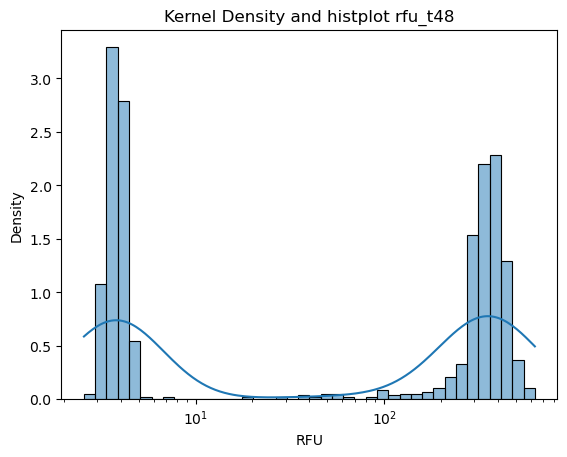

In [17]:
# PLOT_4_t48
# plot a density kernel and histogram of all the data
sns.histplot(df_t48cd["rfu"],bins = 40, kde=True, stat='density', log_scale=True)
plt.title('Kernel Density and histplot rfu_t48')
plt.xlabel("RFU")
plt.ylabel('Density')
plt.show()

The experimental data contains a mix of wells without growth, centered at an RFU value near 3 and wells with growth centered near 350.

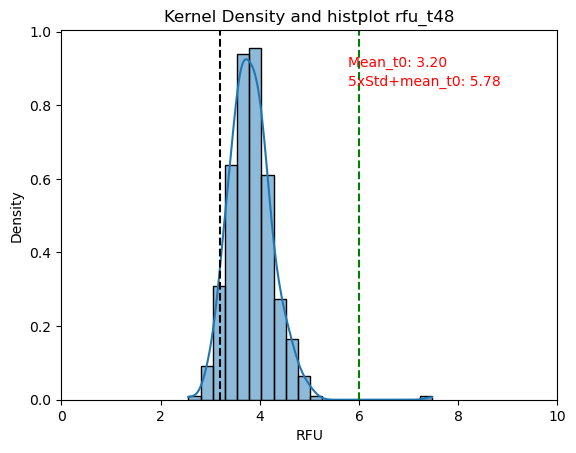

In [18]:
# PLOT_4_t48
# plot a density kernel and histogram of all the T48 data with an RFU of less than 20 to visualize the negative rows 

sns.histplot(df_t48cd[df_t48cd['rfu'] <20]['rfu'], bins = 20, kde=True, stat='density')
plt.title('Kernel Density and histplot rfu_t48')
plt.xlabel("RFU")
plt.ylabel('Density')

plt.text(upper_limit_t0, plt.ylim()[1] * 0.9, f'Mean_t0: {mean_value_t0:.2f}', color='red')
plt.text(upper_limit_t0, plt.ylim()[1] * 0.85, f'5xStd+mean_t0: {upper_limit_t0:.2f}', color='red')

plt.axvline(mean_value_t0, color='black', linestyle='--', label='mean value')
plt.axvline(6, color='green', linestyle='--', label='Upper Limit')
plt.xlim(0,10)
plt.show()

Plot the T0 and T48 data together

In [19]:
df_t0cd['time'] = 'T0'
df_t48cd['time'] = 'T48'
df_all = pd.concat([df_t0cd, df_t48cd])

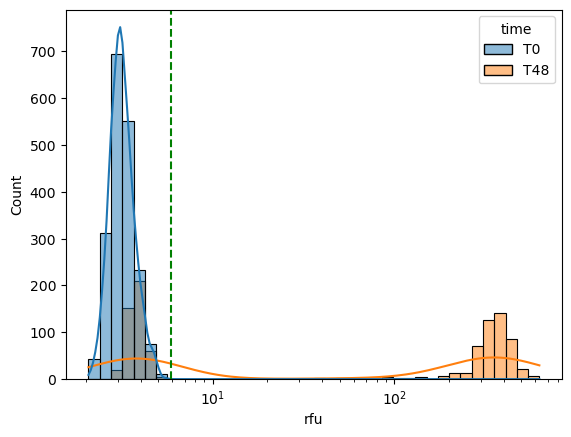

In [20]:
sns.histplot(df_all, x ='rfu', bins = 40, kde=True, hue='time', log_scale=True)
plt.axvline(5.87, color='green', linestyle='--', label='threshold')
plt.show()

# Discussion of plots


We chose the threshold for MicroMPN by looking at the time zero data and comparing it to data after 48 hours of growth. In our experiment, $5\sigma\$ was a good threshold cutoff. We had good signal separation since fluorescence was high in our fluorescently labeled bacterium.

## Why drop early dilutions?

With soil supernatant, the first two 10x dilutions contain particles that scatter light and create a small signal that can be falsely counted as positive wells in the plots.  MicroMPN handles this by ignoring early dilutions if it detects a lower dilution with all positive tubes so in most cases, there is no need to do this to the data that you process with MicroMPN, but when plotting it is helpful to remove the first two dilutions.

## Threshold Caveats

RFU values only slightly above the threshold can indicate that _Ralstonia_ is present, 
particularly at lower dilution factors, which are particularly susceptible to the overgrowth of other microbes in the environment.
At higher dilution factors this effect disappears as background microbes are diluted out, permitting the growth of the target.

Common sense should still be used to visually inspect a few plates used to generate data before running MicroMPN. 

For instance, a plate with consistently low RFU across all other plate replicates might 
indicate a systemic issue with target growth (see image below; data for synthetic community 6),
plasmid retention, incubation conditions, overgrowth of background, etc. 

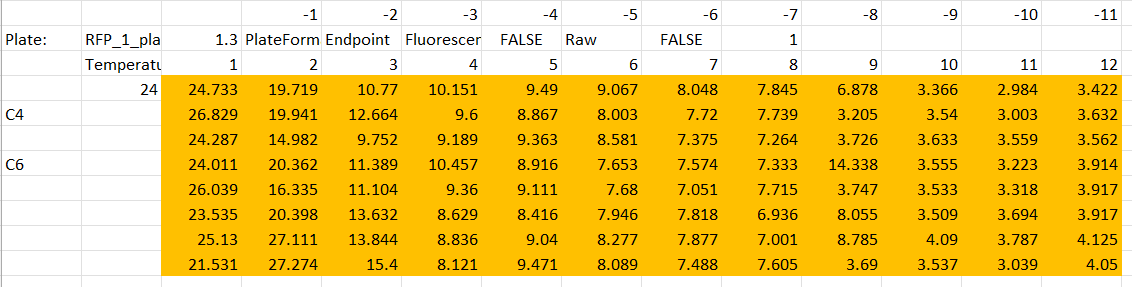

In this situation, even though the plate could be used to generate an MPN estimate, 
compared to other plates in the same series and experiment, 
there appears to be a problem with the expression of the fluorophore. 

In this case more sensitive molecular techniques (e.g. qPCR) should be employed or the pate should be reprocessed.
